In [1]:
import sys
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [2]:
import os
os.chdir("/project/work/Passenger_Demand")

## 패키지 설치
!pip install seaborn
!pip install haversine
!pip install pyarrow
!pip install multiprocessing_on_dill
!pip install statsmodels

In [3]:
import pandas as pd
import numpy as np
import math
import numbers

from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = 'Nanum Gothic'
sns.set(font="NanumGothic")

In [5]:
%%time
mybicard_401 = pd.read_parquet('model_mr/mybicard_401.parquet', engine='pyarrow')

CPU times: user 1.72 s, sys: 1.05 s, total: 2.77 s
Wall time: 1.15 s


In [6]:
mybicard_401["10min_interval"] = mybicard_401["transdate"].dt.minute // 10

In [7]:
# 경주시, 양산시, 울산광역시, 부산광역시
bus_stop = pd.read_csv("data/울산광역시_버스 정류소 위치 정보_20200531.csv", encoding = "euc-kr")
bus_stop = bus_stop.loc[bus_stop["권역"] == "울산광역시"]
bus_stop.columns = ["stop_nm", "stop_id", "longitude", "latitude", "city"]

In [8]:
bus_stop.head(3)

,stop_nm,stop_id,longitude,latitude,city
102,중앙여고,11101,129.343599,35.553219,울산광역시
103,중앙여고,11102,129.343621,35.553309,울산광역시
104,강변이편한세상,11104,129.347783,35.554441,울산광역시


In [9]:
#마이비데이터 정류장번호를 실제 정류장번호와 매핑(by 박세호선임)
bus_stop_401_1 = pd.read_csv("data/401_율리_꽃바위.csv", encoding = "euc_kr")
bus_stop_401_1['direction'] = '1'
bus_stop_401_2 = pd.read_csv("data/401_꽃바위_율리.csv", encoding = "euc_kr")
bus_stop_401_2['direction'] = '2'
bus_stop_401 = pd.concat([bus_stop_401_1, bus_stop_401_2])
bus_stop_401.columns = ["mybi_stop_id", "stop_id", 'direction']

In [10]:
bus_stop_401.head(3)

,mybi_stop_id,stop_id,direction
0,3100597,30504,1
1,3100339,30714,1
2,3101462,30712,1


In [11]:
bus_stop_ulsan = pd.merge(bus_stop_401, bus_stop[["stop_id", "longitude", "latitude", "stop_nm"]], on = "stop_id", how = "inner")

In [12]:
bus_stop_ulsan.shape

(131, 6)

In [13]:
bus_stop_ulsan.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm
0,3100597,30504,1,129.246863,35.529520,율리공영차고지
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞


In [14]:
def calDist(data1, data2):
    point1 = (data1['latitude'], data1['longitude'])
    point2 = (data2['위도'], data2['경도'])
        
    if point1[0] is None or point1[1] is None or point2[0] is None or point2[1] is None:
        return None
    if math.isnan(point1[0]) | math.isnan(point1[1]) | math.isnan(point2[0]) | math.isnan(point2[1]):
        return None
    assert isinstance(point1[0], numbers.Number) and -90<=point1[0] and point1[0]<=90
    assert isinstance(point1[1], numbers.Number) and -180<=point1[1] and point1[1]<=180
    assert isinstance(point2[0], numbers.Number) and -90<=point2[0] and point2[0]<=90
    assert isinstance(point2[1], numbers.Number) and -180<=point2[1] and point2[1]<=180
    
    dist_between = haversine(point1, point2, unit = 'm')
    return round(dist_between, 0)

In [15]:
bus_stop_ulsan_1 = bus_stop_ulsan[bus_stop_ulsan['direction']=='1'].copy()
bus_stop_ulsan_1['경도'], bus_stop_ulsan_1['위도'] = bus_stop_ulsan_1.shift(1)['longitude'], bus_stop_ulsan_1.shift(1)['latitude']
bus_stop_ulsan_1['dist'] = bus_stop_ulsan_1.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_1

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,경도,위도,dist
0,3100597,30504,1,129.246863,35.529520,율리공영차고지,NaN,NaN,NaN
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구,129.246863,35.529520,1166.0
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞,129.255322,35.537435,325.0
3,3101461,30708,1,129.260306,35.543755,울산대학교앞,129.257440,35.539800,511.0
4,3100479,30706,1,129.261981,35.546813,울산대학교후문,129.260306,35.543755,372.0
5,3101460,30704,1,129.263036,35.548831,신복로터리,129.261981,35.546813,244.0
6,3101459,22401,1,129.263912,35.545871,옥현주공아파트앞,129.263036,35.548831,339.0
7,3101458,22403,1,129.264386,35.541685,성광여고앞,129.263912,35.545871,467.0
8,3101457,40601,1,129.279146,35.537109,공원묘지입구,129.264386,35.541685,1429.0
9,3100176,40604,1,129.283144,35.536061,옥동중학교앞,129.279146,35.537109,380.0


In [16]:
bus_stop_ulsan_2 = bus_stop_ulsan[bus_stop_ulsan['direction']=='2'].copy()
bus_stop_ulsan_2['경도'], bus_stop_ulsan_2['위도'] = bus_stop_ulsan_2.shift(1)['longitude'], bus_stop_ulsan_2.shift(1)['latitude']
bus_stop_ulsan_2['dist'] = bus_stop_ulsan_2.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_2

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,경도,위도,dist
64,3100440,19014,2,129.409749,35.478117,꽃바위,NaN,NaN,NaN
65,3101560,25001,2,129.412074,35.477899,화암,129.409749,35.478117,212.0
66,3101559,25003,2,129.415841,35.481411,현대비치타운,129.412074,35.477899,518.0
67,3101558,25005,2,129.418852,35.483501,우성현대아파트,129.415841,35.481411,358.0
68,3100413,25011,2,129.422853,35.485310,해피랜드아파트앞,129.418852,35.483501,414.0
69,3100086,25007,2,129.424330,35.485841,방어동 행정복지센터,129.422853,35.485310,146.0
70,3100433,25009,2,129.425855,35.487869,방어진초등학교,129.424330,35.485841,264.0
71,3101432,24236,2,129.426408,35.491537,대왕암공원입구,129.425855,35.487869,411.0
72,3101431,24234,2,129.428013,35.497744,일산해수욕장,129.426408,35.491537,705.0
73,3101430,24232,2,129.428968,35.501499,번덕마을,129.428013,35.497744,426.0


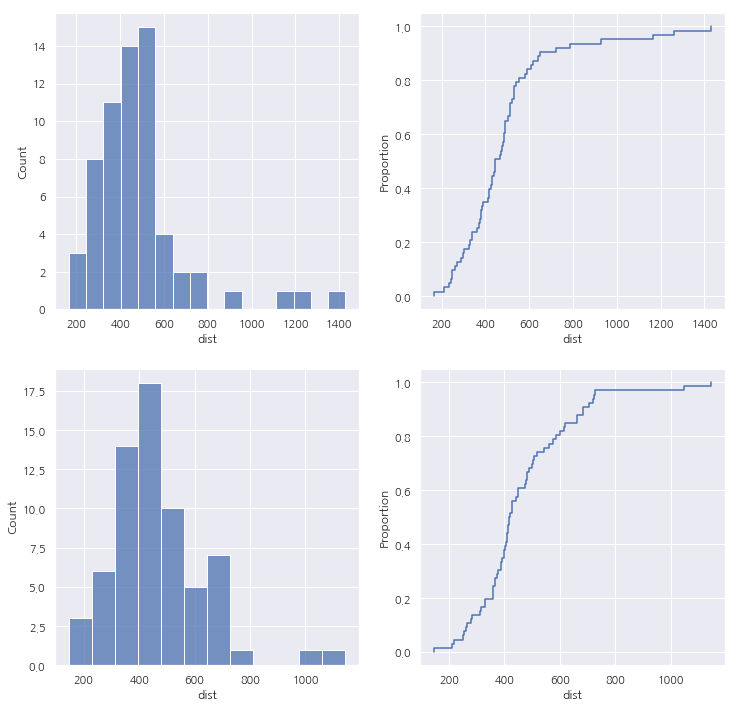

In [17]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
sns.histplot(bus_stop_ulsan_1['dist'], ax=ax1)
ax2 = fig.add_subplot(2,2,2)
sns.ecdfplot(bus_stop_ulsan_1['dist'], ax=ax2)
ax3 = fig.add_subplot(2,2,3)
sns.histplot(bus_stop_ulsan_2['dist'], ax=ax3)
ax4 = fig.add_subplot(2,2,4)
sns.ecdfplot(bus_stop_ulsan_2['dist'], ax=ax4)

In [18]:
bus_stop_ulsan_1.describe()

,mybi_stop_id,stop_id,longitude,latitude,경도,위도,dist
count,6.400000e+01,64.000000,64.000000,64.000000,63.000000,63.000000,63.000000
mean,3.101221e+06,31026.968750,129.362940,35.529956,129.362189,35.530767,485.539683
std,5.720115e+02,7008.917064,0.060508,0.021229,0.060692,0.020374,228.851327
min,3.100057e+06,19016.000000,129.246863,35.477671,129.246863,35.477671,165.000000
25%,3.101193e+06,24228.500000,129.315362,35.524796,129.313682,35.526354,366.000000
50%,3.101454e+06,30618.000000,129.377473,35.535213,129.375853,35.535279,444.000000
75%,3.101483e+06,40404.000000,129.420185,35.540175,129.421187,35.540551,530.000000
max,3.102806e+06,40613.000000,129.432980,35.561309,129.432980,35.561309,1429.000000


In [19]:
marketplace = pd.read_csv('data/울산광역시_상권정보_201231.csv')

In [20]:
marketplace.shape

(52188, 39)

In [21]:
marketplace.head(3)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,20736666,삼산프리미어어학원,NaN,R,학문/교육,R04,학원-어학,R04A01,학원-외국어/어학,P85502,외국어학원,31,울산광역시,31140,남구,3114057000,삼산동,3.114011e+09,삼산동,3.114010e+18,1,대지,1546,3.0,울산광역시 남구 삼산동 1546-3,3.114030e+11,울산광역시 남구 돋질로,286,NaN,3.114010e+24,NaN,울산광역시 남구 돋질로 286,680816,44705,NaN,NaN,NaN,129.336091,35.544065
1,24090929,왕생이입시단과학원,NaN,R,학문/교육,R01,학원-보습교습입시,R01A01,학원-입시,P85501,일반 교과 학원,31,울산광역시,31140,남구,3114055000,신정5동,3.114010e+09,신정동,3.114010e+18,1,대지,80,19.0,울산광역시 남구 신정동 80-19,3.114040e+11,울산광역시 남구 월평로147번길,5,NaN,3.114010e+24,NaN,울산광역시 남구 월평로147번길 5,680010,44685,NaN,NaN,NaN,129.320966,35.545070
2,21683173,이벤트기획연,NaN,F,생활서비스,F20,행사/이벤트,F20A02,이벤트기획,N75992,전시 및 행사 대행업,31,울산광역시,31140,남구,3114055000,신정5동,3.114010e+09,신정동,3.114060e+18,1,대지,236,107.0,울산광역시 남구 신정동 236-107,3.114030e+11,울산광역시 남구 월평로,141,NaN,3.114010e+24,NaN,울산광역시 남구 월평로 141,680010,44685,NaN,NaN,NaN,129.320748,35.544531


In [22]:
list(marketplace['상권업종중분류명'].unique())

['학원-어학',
 '학원-보습교습입시',
 '행사/이벤트',
 '한식',
 '학문교육기타',
 '의약/의료품소매',
 '종합소매점',
 '기타음식업',
 '유흥주점',
 '커피점/카페',
 '음/식료품소매',
 '이/미용/건강',
 '자동차/자동차용품',
 '가방/신발/액세서리',
 '호텔/콘도',
 '운동/경기용품소매',
 '유아교육',
 '화장품소매',
 '모텔/여관/여인숙',
 '학원-음악미술무용',
 '학원기타',
 '선물/팬시/기념품',
 '부동산중개',
 '닭/오리요리',
 '가정/주방/인테리어',
 '일식/수산물',
 'PC/오락/당구/볼링등',
 '제과제빵떡케익',
 '의복의류',
 '책/서적/도서',
 '중식',
 '건강/미용식품',
 '자동차/이륜차',
 '기타판매업',
 '분식',
 '사진/광학/정밀기기소매',
 '주유소/충전소',
 '세탁/가사서비스',
 '별식/퓨전요리',
 '가전제품소매',
 '양식',
 '민박/하숙',
 '인력/고용/용역알선',
 '철물/난방/건설자재소매',
 '페인트/유리제품소매',
 '무도/유흥/가무',
 '시계/귀금속소매',
 '주택수리',
 '가구소매',
 '장례/묘지',
 '도서관/독서실',
 '물품기기대여',
 '사무/문구/컴퓨터',
 '학원-예능취미체육',
 '캠프/별장/펜션',
 '학원-자격/국가고시',
 '중고품소매/교환',
 '개인서비스',
 '운송/배달/택배',
 '기타서비스업',
 '패스트푸드',
 '요가/단전/마사지',
 '경마/경륜/성인오락',
 '취미/오락관련소매',
 '대중목욕탕/휴게',
 '예식/의례/관혼상제',
 '분양',
 '애견/애완/동물',
 '광고/인쇄',
 '개인/가정용품수리',
 '유아용품',
 '사진',
 '학원-컴퓨터',
 '부페',
 '학원-창업취업취미',
 '연극/영화/극장',
 '대행업',
 '실내운동시설',
 '예술품/골동품/수석/분재',
 '놀이/여가/취미',
 '스포츠/운동',
 '법무세무회계',
 '음식배달서비스',
 '운영관리시설',
 '종교용품판매',
 

In [23]:
bus_stop_ulsan.shape

(131, 6)

In [24]:
marketplace.shape

(52188, 39)

In [25]:
from multiprocessing_on_dill import Pool, cpu_count
from functools import partial
import pandas as pd
import numpy as np

def parallelize_dataframe(df, 
                          func, 
                          group_keys = None, 
                          num_cores = None,
                          **params):
    """
        Pandas DataFrame의 apply함수를 병렬처리 하는 함수

        Args: 
            df: 적용 대상 데이터프레임 (Pandas.DataFrame)
            group_keys: apply를 적용할 때 기준이되는 group by key

        Returns:
            df: (Pandas.DataFrame)
            
        Exception: 
    """

    if num_cores is None:
        num_cores = cpu_count()

    if group_keys is None:
        df_list = np.array_split(df, num_cores)
    elif group_keys is not None:
        gr_df = df.groupby(group_keys)
        df_list = [group for name, group in gr_df]
    
#     func = partial(func, **params)
    
    def map_func(data):
        return data.apply(func, axis = 1, **params)
        
        
    with Pool(num_cores) as p:

        pd_result = pd.concat(p.map(map_func, df_list))
#         pd_result = p.starmap(func, **params)
        
    return pd_result

In [26]:
bus_stop_ulsan.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm
0,3100597,30504,1,129.246863,35.529520,율리공영차고지
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞


In [27]:
def countNearMarket(bus_stop, marketDf, dist = 250, category_list = None):
    data_copy = bus_stop.copy()
    if category_list == None:
        category_list = list(marketDf['상권업종중분류명'].unique())
        
    dist_list = marketDf.apply(lambda x: calDist(bus_stop, x), 1)
    within_data = marketDf.loc[dist_list <= dist]
    
    for i, ctgr in enumerate(category_list):
        data_copy[f"market_lv2_{i}"] = (within_data["상권업종중분류명"] == ctgr).sum()

    return data_copy

In [27]:
%%time
bus_stop_401_store = parallelize_dataframe(df = bus_stop_ulsan, func = countNearMarket, num_cores = 10, marketDf = marketplace, dist = 250)

CPU times: user 16.7 s, sys: 643 ms, total: 17.3 s
Wall time: 1min 51s


In [28]:
bus_stop_401_store.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89
0,3100597,30504,1,129.246863,35.529520,율리공영차고지,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구,0,4,0,15,0,0,8,0,0,6,2,10,3,0,0,0,2,3,1,3,2,1,6,3,4,8,1,0,2,1,0,1,5,1,2,0,0,5,0,0,3,0,0,2,0,0,0,1,0,0,1,0,3,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞,3,7,0,45,0,0,15,1,9,18,6,24,1,1,0,1,3,4,0,5,2,3,8,12,4,7,8,0,12,1,9,3,2,4,22,5,0,5,0,0,10,0,3,2,0,5,1,1,0,0,4,0,13,1,0,0,0,0,0,1,3,0,1,0,0,0,1,1,0,5,0,3,1,0,1,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
%%time
hospital_data = pd.read_parquet('model_mr/hospital_data.parquet', engine='pyarrow')

CPU times: user 25.8 ms, sys: 8.34 ms, total: 34.1 ms
Wall time: 99.7 ms


In [30]:
hospital_data.head(3)

,의료기관명,의료기관종별,의료기관주소(도로명),lat_lng,lat,lng
0,의료법인 정안의료재단 중앙병원,종합병원,울산광역시 남구 문수로480번길 10 (신정동),"{'lat': 35.5315233, 'lng': 129.3052032}",35.531523,129.305203
1,의료법인 은성의료재단 좋은삼정병원,종합병원,울산광역시 남구 북부순환도로 51 (무거동),"{'lat': 35.5528284, 'lng': 129.2690588}",35.552828,129.269059
2,의료법인혜명심의료재단 울산병원,종합병원,울산광역시 남구 월평로171번길 13 (신정동),"{'lat': 35.546209, 'lng': 129.3230784}",35.546209,129.323078


In [31]:
hospital_data = hospital_data.rename(columns={"lat":"위도", "lng":"경도"})

In [32]:
def countNearHospital(bus_stop, hospitalDf, dist = 250, category_list = None):
    data_copy = bus_stop.copy()
    if category_list == None:
        category_list = list(hospitalDf['의료기관종별'].unique())
        
    dist_list = hospitalDf.apply(lambda x: calDist(bus_stop, x), 1)
    within_data = hospitalDf.loc[dist_list <= dist]
    
    for i, ctgr in enumerate(category_list):
        data_copy[f"hospital_lv1_{i}"] = (within_data["의료기관종별"] == ctgr).sum()

    return data_copy

In [33]:
%%time
bus_stop_401_hospital = parallelize_dataframe(df = bus_stop_401_store, func = countNearHospital, num_cores = 10, hospitalDf = hospital_data, dist = 250)

CPU times: user 511 ms, sys: 165 ms, total: 676 ms
Wall time: 4.58 s


In [34]:
bus_stop_401_hospital1 = bus_stop_401_hospital.copy()

In [35]:
bus_stop_401_hospital['hospital_lv0'] = bus_stop_401_hospital[[x for x in bus_stop_401_hospital.columns if "hospital" in x]].sum(axis=1)
bus_stop_401_hospital['market_lv0'] = bus_stop_401_hospital[[x for x in bus_stop_401_hospital.columns if "market" in x]].sum(axis=1)

In [36]:
bus_stop_401_hospital.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,3100597,30504,1,129.246863,35.529520,율리공영차고지,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구,0,4,0,15,0,0,8,0,0,6,2,10,3,0,0,0,2,3,1,3,2,1,6,3,4,8,1,0,2,1,0,1,5,1,2,0,0,5,0,0,3,0,0,2,0,0,0,1,0,0,1,0,3,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞,3,7,0,45,0,0,15,1,9,18,6,24,1,1,0,1,3,4,0,5,2,3,8,12,4,7,8,0,12,1,9,3,2,4,22,5,0,5,0,0,10,0,3,2,0,5,1,1,0,0,4,0,13,1,0,0,0,0,0,1,3,0,1,0,0,0,1,1,0,5,0,3,1,0,1,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,314


In [37]:
bus_stop_401_hospital.describe()

,mybi_stop_id,stop_id,longitude,latitude,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
count,1.310000e+02,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.00000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.0,131.000000,131.0,131.000000,131.0,131.000000,131.0,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.00000,131.000000,131.0,131.0,131.0,131.000000,131.000000
mean,3.101186e+06,31049.389313,129.362713,35.529902,3.152672,5.465649,0.076336,26.320611,0.503817,0.366412,7.702290,0.267176,16.595420,8.320611,3.282443,12.687023,1.061069,4.206107,0.374046,1.977099,0.961832,4.862595,2.877863,1.954198,2.022901,1.679389,3.885496,4.114504,3.198473,6.564885,2.007634,2.122137,12.083969,0.679389,2.221374,1.427481,2.580153,0.618321,5.450382,2.885496,0.244275,2.213740,1.045802,1.076336,5.244275,0.0,0.259542,0.694656,0.076336,3.488550,1.122137,0.274809,0.687023,0.076336,0.656489,0.251908,1.335878,0.717557,0.0,0.343511,0.412214,0.213740,0.198473,0.251908,3.099237,1.152672,0.473282,0.267176,0.824427,0.312977,0.305344,0.267176,0.587786,1.061069,0.244275,0.496183,0.21374,0.312977,0.114504,0.091603,0.465649,0.137405,0.106870,0.015267,0.0,0.106870,0.152672,0.0,0.015267,0.0,0.068702,0.0,0.030534,0.0,0.007634,0.152672,0.015267,0.0,0.129771,4.076336,0.015267,2.633588,0.061069,1.29771,1.687023,0.0,0.0,0.0,10.076336,188.366412
std,6.146289e+02,6968.523111,0.061127,0.021265,7.965766,18.318674,0.266554,28.822071,0.979592,0.692888,6.766086,1.013937,28.046055,11.739655,6.632409,16.247170,1.423731,14.385205,1.069406,3.993197,1.309166,12.121033,4.913127,3.941617,3.338506,2.219727,5.226620,5.131563,3.742520,8.250967,3.126798,3.479662,38.669614,1.254329,3.106544,2.270312,2.631040,1.

In [38]:
# 마이비 정류장 ID -> 공공 데이터 정류쟝 ID로 매핑
card_401 = pd.merge(mybicard_401, bus_stop_401_hospital, on = "mybi_stop_id", how = "inner")

In [49]:
card_401.shape

(1964401, 131)

In [50]:
card_401.to_parquet("model_mr/card_401.parquet")

In [39]:
card_401.head(3)

,collectdate,seq,route_nm,transdate,sumamount,stop_nm_x,mybi_stop_id,normalcnt,studentcnt,studentamount,childcnt,childamount,transflag,mybicardnumber,base_ymd,dayofweek,day,month,hour,totalcnt,stop_id,direction,longitude,latitude,stop_nm_y,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,2020-04-07,165242,401,2020-04-08 00:02:42,1250,옥동초등학교,3101416,1,0,0,0,0,비환승,D900508462186,20200408,수,8,4,0,1,40610,2,129.29724,35.534136,옥동초등학교,8,15,0,13,1,0,7,0,5,15,5,25,2,0,0,1,2,3,0,6,6,1,14,12,3,8,0,6,12,1,1,1,0,1,5,6,0,0,2,0,2,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,6,0,1,1,0,0,0,10,203
1,2020-04-08,130625,401,2020-04-08 06:30:06,1250,옥동초등학교,3101416,1,0,0,0,0,비환승,D900578762751,20200408,수,8,4,6,1,40610,2,129.29724,35.534136,옥동초등학교,8,15,0,13,1,0,7,0,5,15,5,25,2,0,0,1,2,3,0,6,6,1,14,12,3,8,0,6,12,1,1,1,0,1,5,6,0,0,2,0,2,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,6,0,1,1,0,0,0,10,203
2,2020-04-08,121407,401,2020-04-08 07:54:00,820,옥동초등학교,3101416,1,0,0,0,0,비환승,D900600754901,20200408,수,8,4,7,1,40610,2,129.29724,35.534136,옥동초등학교,8,15,0,13,1,0,7,0,5,15,5,25,2,0,0,1,2,3,0,6,6,1,14,12,3,8,0,6,12,1,1,1,0,1,5,6,0,0,2,0,2,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,6,0,1,1,0,0,0,10,203


In [40]:
import statsmodels.api as sm
from scipy import stats

In [41]:
X0 = card_401[[x for x in card_401.columns if ("market" in x) | ("hospital" in x)]]
X1 = card_401[[x for x in card_401.columns if "market" in x]]
X2 = card_401[[x for x in card_401.columns if "hospital" in x]]
y = card_401["totalcnt"]

In [44]:
X0_ = sm.add_constant(X0)
est_0 = sm.OLS(y, X0_)
est2_0 = est_0.fit()
print(est2_0.summary())

                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     46.29
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:38:49   Log-Likelihood:             9.0000e+05
No. Observations:             1964401   AIC:                        -1.800e+06
Df Residuals:                 1964307   BIC:                        -1.799e+06
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0185      0.001   12

In [42]:
X1_ = sm.add_constant(X1)
est_1 = sm.OLS(y, X1_)
est2_1 = est_1.fit()
print(est2_1.summary())

                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     50.00
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:37:27   Log-Likelihood:             8.9992e+05
No. Observations:             1964401   AIC:                        -1.800e+06
Df Residuals:                 1964317   BIC:                        -1.799e+06
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0166      0.001   1428.792

In [43]:
X2_ = sm.add_constant(X2)
est_2 = sm.OLS(y, X2_)
est2_2 = est_2.fit()
print(est2_2.summary())

/home/ds_user1/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     98.76
Date:                Thu, 25 Mar 2021   Prob (F-statistic):          9.69e-206
Time:                        01:37:28   Log-Likelihood:             8.9834e+05
No. Observations:             1964401   AIC:                        -1.797e+06
Df Residuals:                 1964390   BIC:                        -1.797e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0186      0.000   54

In [45]:
p_values0 = est2_0.pvalues
insignificant_list0 = p_values0.loc[p_values0 >=0.05]
insignificant_list0

market_lv2_1      0.421831
market_lv2_2      0.795156
market_lv2_3      0.379845
market_lv2_6      0.592710
market_lv2_7      0.635753
market_lv2_8      0.329683
market_lv2_9      0.968916
market_lv2_10     0.351990
market_lv2_12     0.573471
market_lv2_13     0.299506
market_lv2_15     0.140665
market_lv2_19     0.602984
market_lv2_21     0.221503
market_lv2_22     0.572088
market_lv2_23     0.919208
market_lv2_24     0.847351
market_lv2_26     0.081771
market_lv2_27     0.412161
market_lv2_28     0.207829
market_lv2_29     0.679810
market_lv2_30     0.726711
market_lv2_31     0.066142
market_lv2_32     0.941904
market_lv2_34     0.284654
market_lv2_38     0.257426
market_lv2_39     0.317468
market_lv2_40     0.698215
market_lv2_42     0.867026
market_lv2_43     0.785714
market_lv2_45     0.756517
market_lv2_46     0.432178
market_lv2_47     0.396973
market_lv2_50     0.082178
market_lv2_51     0.239824
market_lv2_52     0.428680
market_lv2_53     0.117034
market_lv2_54     0.431868
m

In [48]:
p_values1 = est2_1.pvalues
insignificant_list1 = p_values1.loc[p_values1 >=0.05]
insignificant_list1

market_lv2_2     0.487469
market_lv2_9     0.401396
market_lv2_12    0.117524
market_lv2_14    0.188822
market_lv2_17    0.497581
market_lv2_18    0.524894
market_lv2_24    0.091977
market_lv2_25    0.759836
market_lv2_27    0.234572
market_lv2_31    0.520314
market_lv2_32    0.268990
market_lv2_33    0.824608
market_lv2_35    0.096185
market_lv2_37    0.702950
market_lv2_42    0.083869
market_lv2_44    0.073904
market_lv2_45    0.697584
market_lv2_47    0.877794
market_lv2_48    0.051874
market_lv2_58    0.724961
market_lv2_59    0.184109
market_lv2_60    0.871331
market_lv2_61    0.086051
market_lv2_63    0.956548
market_lv2_65    0.134857
market_lv2_66    0.626580
market_lv2_67    0.622294
market_lv2_77    0.246480
market_lv2_78    0.538169
market_lv2_81    0.326480
dtype: float64

In [47]:
p_values2 = est2_2.pvalues
insignificant_list2 = p_values2.loc[p_values2 >=0.05]
insignificant_list2

hospital_lv1_7    0.629012
hospital_lv1_9    0.715507
dtype: float64